In [1]:
import numpy as np
from imageio.v3 import imread
import matplotlib.pyplot as plt

from numba import njit

import heapq
from typing import Any

## Reading an image

Use the image you want (it must be a grayscale image encoded as `uint8`).

In [2]:
IMAGE_PATH = "C:\\Users\\marce\\Desktop\\s8\\TP1\\TP1\\data\\img.png" # Change the path to point to your image
MASK_PATH = "C:\\Users\\marce\\Desktop\\s8\\TP1\\TP1\\data\\mask.png"
img = imread(IMAGE_PATH)
mask = imread(MASK_PATH)

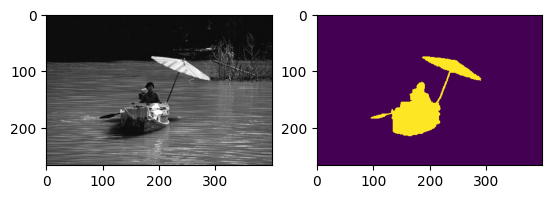

In [3]:
plt.subplot(121)
plt.imshow(img, cmap="gray")
plt.subplot(122)
plt.imshow(mask)
plt.show()

## A priority queue

Implement a priority queue that handles the following operations:
* `push(p, v)`: Pushes an element `v` into the queue at priority `p`. If `v` is already in the queue, update the priority.
* `pop() -> (p, v)`: Pops the element `v` with the highest priority `p`
* `empty() -> bool`: Returns `True` if the queue is empty.

**Advice:** You may implement a lazy heap, that means a heap that only heapify at `pop` operation. Furthermore, you may take advantages of the reference system in Python to implement your heap by storing the priority and the value in a structure such that you just change the priority at the push operation. Look at [dict](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) and [heapq](https://docs.python.org/fr/3/library/heapq.html) for advices !

In [4]:
class PQueue:
    def __init__(self):
        self.heap = []

    def push(self, p: float, v):
        if isinstance(v, np.ndarray):
            v = tuple(v)
        heapq.heappush(self.heap, (p, v))

    def pop(self):
        if self.heap:
            p, v = heapq.heappop(self.heap)
            return p, v
        return None

    def empty(self):
        return len(self.heap) == 0

In [5]:
q = PQueue()
q.push(7, 0)
q.push(6, 1)
q.push(3, 0)

In [6]:
while not q.empty():
    (p, v) = q.pop()
    print(f"(v: {v}, p: {p})")

(v: 0, p: 3)
(v: 1, p: 6)
(v: 0, p: 7)


This small test may print :

```
(v: 0, p: 3)
(v: 1, p: 6)
```

## Implementation of the geodesic distance transform using propagation

The propagation is based on the [Fast Marching Methods](https://en.wikipedia.org/wiki/Fast_marching_method), a derived Dijkstra algorithm, and aims to compute a distance map. It uses the previously defined priority queue.

It is defined as follow:
* Create a distance mapping `D` whose values are sufficiently high (1e10)
* For each seed point (`mask > 0`), put the distance value at 0 and inqueue the seed points `(l, c)` in the queue at priority 0.
* While the queue is not empty:
    * Pop the element $p$ with the highest priority
    * For each neighbors $n$:
        * Compute the new distance $d_{new} = D(p) + |img(p) - img(n)|$
        * If $d_{new} < D(n)$, $D(n) = d_{new}$ and update the priority of $n$ in the queue.

In [15]:
def setstatut(d,heap,img,status,y2,x2,y1,x1):
    if status[y2,x2] != "fait":
        dnew = d[y1,x1]  + abs(float(img[y1,x1]) - float(img[y2,x2]))
        if dnew < d[y2,x2]:
            d[y2,x2] = dnew
            heap.push(dnew,(y2,x2))

        
def propagation(img: np.ndarray, mask: np.ndarray) -> np.ndarray:
    d = np.full(shape=img.shape,fill_value=1e10)
    status = np.full(shape=img.shape,fill_value="non_fait")
    d[mask > 0] = 0
    heap = PQueue()
    for i in np.argwhere(mask):
        status[i[0],i[1]] = "fait"
        heap.push(0,i)
    while not heap.empty():
        p = heap.pop()
        coord = p[1]
        coord_y = coord[0]
        coord_x = coord[1]
        status[coord_y,coord_x] = "fait"
        imin = max(coord_y - 1,0)
        imax = min(coord_y + 1,d.shape[0] - 1)
        jmin = max(coord_x - 1 , 0)
        jmax  = min(coord_x + 1, d.shape[1] - 1)
        setstatut(d,heap,img,status,imin,jmin,coord_y,coord_x)
        setstatut(d,heap,img,status,imin,coord_x,coord_y,coord_x)
        setstatut(d,heap,img,status,imin,jmax,coord_y,coord_x)
        setstatut(d,heap,img,status,coord_y,jmin,coord_y,coord_x)
        setstatut(d,heap,img,status,coord_y,jmax,coord_y,coord_x)
        setstatut(d,heap,img,status,imax,jmin,coord_y,coord_x)
        setstatut(d,heap,img,status,imax,coord_x,coord_y,coord_x)
        setstatut(d,heap,img,status,imax,jmax,coord_y,coord_x)
    return d

In [16]:
D = propagation(img, mask)

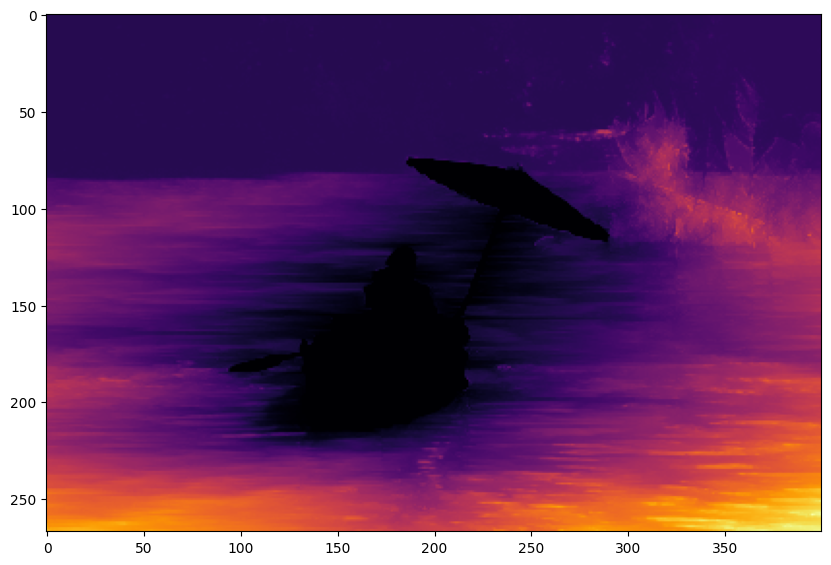

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(D, cmap="inferno")

## Efficient implementation of the geodesic distance transform

Once your implementation of the propagation work, improve your implementation to have the best performance possible (algorithmic optimization, data structure, [Numba](https://numba.pydata.org/), ...). Be careful: the Numba version will require to avoid the use of some element of the code

In [10]:
# TODO

import numba

heap_type = np.dtype([
    ('x',np.int64),
    ('y',np.int64)
])


TurpleArgument = numba.types.Tuple([numba.types.int64,numba.types.int64])
ValueList = numba.types.ListType(TurpleArgument)
Float = numba.types.float64

#ValueDict = numba.types.DictType(float,ValueList)


@njit
def push(values: dict, p, v):
        if  (p in values):
            values[p].append(v)
        else:
            tuple = (v[0],v[1])
            list_to_add = [tuple]
            values[p] = numba.typed.typedlist.List(list_to_add)


@njit
def pop(values):
        if empty(values):
            return None
        else:
            key = -1
            for p in values:
                if key == -1 or p < key:
                    key = p
            info = values[key]
            response = (key,info.pop(0))
            if (len(info) == 0):              
                values.pop(key)
            return response


@njit
def empty(values):
        return len(values) == 0
@njit
def setstatut_njit(d,heap,img,status,y2,x2,y1,x1):
    if status[y2,x2] != "fait":
        dnew = d[y1,x1]  + abs(float(img[y1,x1]) - float(img[y2,x2]))
        if dnew < d[y2,x2]:
            d[y2,x2] = dnew
            push(heap,dnew,(y2,x2))

        
@njit
def propagation_njit( img: np.ndarray, mask: np.ndarray) -> np.ndarray:

    heap = numba.typed.typeddict.Dict.empty(Float,ValueList)
    d = np.full(shape=img.shape,fill_value=1e10)
    status = np.full(shape=img.shape,fill_value="non_fait")
    
    len_y = mask.shape[0]
    len_x = mask.shape[1]
    for  i in range(len_y):
        for j in range(len_x):
            if (mask[i,j] > 0):
                d[i,j] = 0
                status[i,j] = "fait"
                push(heap,0,(i,j))
    while not empty(heap):
        p = pop(heap)
        priority, coordonnees = p
        coord_y, coord_x = coordonnees
        status[coord_y,coord_x] = "fait"
        imin = max(coord_y - 1,0)
        imax = min(coord_y + 1,d.shape[0] - 1)
        jmin = max(coord_x - 1 , 0)
        jmax  = min(coord_x + 1, d.shape[1] - 1)
        setstatut_njit(d,heap,img,status,imin,jmin,coord_y,coord_x)
        setstatut_njit(d,heap,img,status,imin,coord_x,coord_y,coord_x)
        setstatut_njit(d,heap,img,status,imin,jmax,coord_y,coord_x)
        setstatut_njit(d,heap,img,status,coord_y,jmin,coord_y,coord_x)
        setstatut_njit(d,heap,img,status,coord_y,jmax,coord_y,coord_x)
        setstatut_njit(d,heap,img,status,imax,jmin,coord_y,coord_x)
        setstatut_njit(d,heap,img,status,imax,coord_x,coord_y,coord_x)
        setstatut_njit(d,heap,img,status,imax,jmax,coord_y,coord_x)
    
    return d



In [18]:
import numba

D = propagation_njit(img, mask)

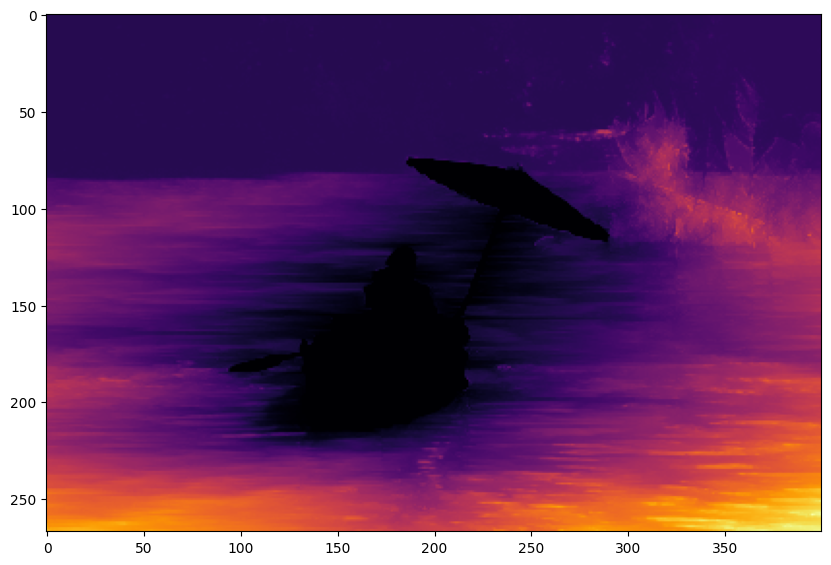

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(D, cmap="inferno")